## PyTorchによるオートエンコーダーの実装

### MNISTデータセットのダウンロード

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#トランスフォームオブジェクトを生成
transform = transforms.Compose(
    [transforms.ToTensor(), #Tensorオブジェクトに変換
    lambda x: x.view(-1)]) #データの形状を(28, 28)から(784,)に変換

#MNISTの訓練用データ
mnist_train = torchvision.datasets.MNIST(
    #ノートブックと同じ「Autoencoder_PyTorch」以下の「mnist_root」に保存
    #Autoencoder_PyTorchのパスを事前に取得しておく
    root='/Users/長山　湧/PycharmProjects/pythonProject1/Autoencoder_PyTorch/mnist_root',
    download=True,#ダウンロードを許可
    train=True,#訓練データを指定
    transform=transform #トランスフォームオブジェクト
)

# MNISTのテスト用データ
mnist_test = torchvision.datasets.MNIST(
    #ノートブックと同じ「Autoencoder_PyTorch」以下の「mnist_root」に保存
    #Autoencoder_PyTorchのパスを事前に取得しておく
    root='/Users/長山　湧/PycharmProjects/pythonProject1/Autoencoder_PyTorch/mnist_root',
    download=True,
    train=False,
    transform=transform
)

#データローダーを生成
train_dataloader = DataLoader(mnist_train,#訓練データ
                              batch_size=124,#ミニバッチのサイズ
                              shuffle=True)#抽出時にシャッフル

test_dataloader = DataLoader(mnist_test,#テストデータ
                             batch_size=1,#テストなので1
                             shuffle=False)#抽出時にシャッフルしない

### デバイスの確認

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

### オートエンコーダーを生成するクラス

In [4]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device=device
        self.l1 = nn.Linear(784, 200)#エンコーダー（200ユニット）
        self.l2 = nn.Linear(200,784)#エンコーダー（784ユニット）

    def forward(self, x):
        h = self.l1(x)          #エンコーダーに入力
        h = torch.relu(h)       #ReLU関数を適用

        h = self.l2(h)          #デコーダーに入力
        y = torch.sigmoid(h)    #シグモイド関数を適用

        return y

### オートエンコーダーの生成

In [5]:
import torch.optim as optimizers

#オートエンコーダーを生成
model = Autoencoder(device=device).to(device)
#損失関数はバイナリクロスエントロピー誤差
criterion = nn.BCELoss()
#オプティマイザー（最適化関数）をAdamに設定
optimizer = optimizers.Adam(model.parameters())

### 学習を行う

In [7]:
#エポック数
epochs = 10

#学習の実行
for epoch in range(epochs):
    train_loss = 0.
    #ミニバッチのループ（ステップ）
    for (x, _) in train_dataloader:
        x = x.to(device)                    #デバイスの割り当て
        model.train()                       #訓練モードにする
        preds = model(x)                    #モデルの出力を取得
        loss = criterion(preds, x)          #入力xと復元predsの誤差を取得
        optimizer.zero_grad()               #勾配を0で初期化
        loss.backward()                     #誤差の勾配を計算
        optimizer.step()                    #パラメーターの更新

        train_loss += loss.item()           #誤差（損失）の更新
    #1エポックあたりの損失を求める
    train_loss /= len(train_dataloader)
    #1エポックごとに損失を出力
    print('Epoch({}) -- Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch(1) -- Loss: 0.098
Epoch(2) -- Loss: 0.079
Epoch(3) -- Loss: 0.073
Epoch(4) -- Loss: 0.071
Epoch(5) -- Loss: 0.069
Epoch(6) -- Loss: 0.068
Epoch(7) -- Loss: 0.067
Epoch(8) -- Loss: 0.067
Epoch(9) -- Loss: 0.066
Epoch(10) -- Loss: 0.066


### 復元された画像を表示してみる

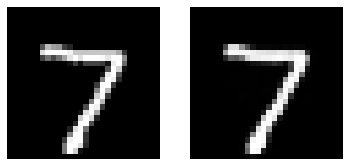

In [9]:
import  matplotlib.pyplot as plt
%matplotlib inline

#テストデータを1個取り出す
x, _ = next(iter(test_dataloader))
x = x.to(device)

#ネットワークを評価モードにする
model.eval()
#テストデータを入力して結果を取得する
x_rec = model(x)

#入力画像、復元画像を表示
for i, image in enumerate([x, x_rec]):
    image = image.view(28, 28).detach().cpu().numpy()
    plt.subplot(1, 2, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.show()